## **Load Data**
---

### Install the required packages

In [42]:
# remove the '#' to run the command, this is a python script
#pip install -r requirements.txt

### Import and read the csv file

In [43]:
import pandas as pd

pd.set_option('display.float_format', lambda x: '%.3f' % x)

raw = pd.read_csv("insurance.csv")

## **Transform Data**
--- 

### Rename the English column names to Portuguese language

In [44]:
raw.rename(
    columns={
        "age": "idade",
        "sex": "genero",
        "bmi": "imc",
        "children": "filhos",
        "smoker": "fumante",
        "region": "regiao",
        "charges": "encargos",
    },
    inplace=True,
)

### Convert the column names and values to Portuguese language

In [45]:
def region_replace(value):
    return {
        "southwest": "sudoeste",
        "southeast": "sudeste",
        "northwest": "noroeste",
        "northeast": "nordeste",
    }.get(value, value)


raw["regiao"] = raw["regiao"].apply(region_replace)
raw["genero"] = raw["genero"].apply(lambda value: value == "male")# "masculino" if value == "male" else "feminino")
raw["fumante"] = raw["fumante"].apply(lambda value: "sim" if value == "yes" else "não")

raw

,idade,genero,imc,filhos,fumante,regiao,encargos
0,19,False,27.900,0,sim,sudoeste,16884.924
1,18,True,33.770,1,não,sudeste,1725.552
2,18,False,27.900,0,sim,sudoeste,16884.924
3,19,True,33.770,1,não,sudeste,1725.552
4,20,True,33.000,3,não,sudeste,4449.462
...,...,...,...,...,...,...,...
1549,50,True,30.970,3,não,noroeste,10600.548
1550,18,False,31.920,0,não,nordeste,2205.981
1551,18,False,36.850,0,não,sudeste,1629.833
1552,21,False,25.800,0,não,sudoeste,2007.945


# **Data Display**
---

We need to show the data macros and main caracteristics for the data set, as types, values, using statistics and graphs.

### Exploratory Data Analysis (EDA)

#### Dataset Information

In [46]:
raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1554 entries, 0 to 1553
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   idade     1554 non-null   int64  
 1   genero    1554 non-null   bool   
 2   imc       1554 non-null   float64
 3   filhos    1554 non-null   int64  
 4   fumante   1554 non-null   object 
 5   regiao    1554 non-null   object 
 6   encargos  1554 non-null   float64
dtypes: bool(1), float64(2), int64(2), object(2)
memory usage: 74.5+ KB


#### Dataset Shape

In [47]:
raw.describe()

,idade,imc,filhos,encargos
count,1554.000,1554.000,1554.000,1554.000
mean,39.276,30.727,1.080,13345.287
std,14.502,6.070,1.200,12166.395
min,18.000,15.960,0.000,1121.874
25%,26.000,26.296,0.000,4625.250
50%,39.000,30.495,1.000,9502.442
75%,52.000,34.800,2.000,16862.796
max,70.000,53.130,5.000,63770.428


#### Dataset Null Values

In [48]:
raw.isnull().sum()

idade       0
genero      0
imc         0
filhos      0
fumante     0
regiao      0
encargos    0
dtype: int64

### Distribution Graphs

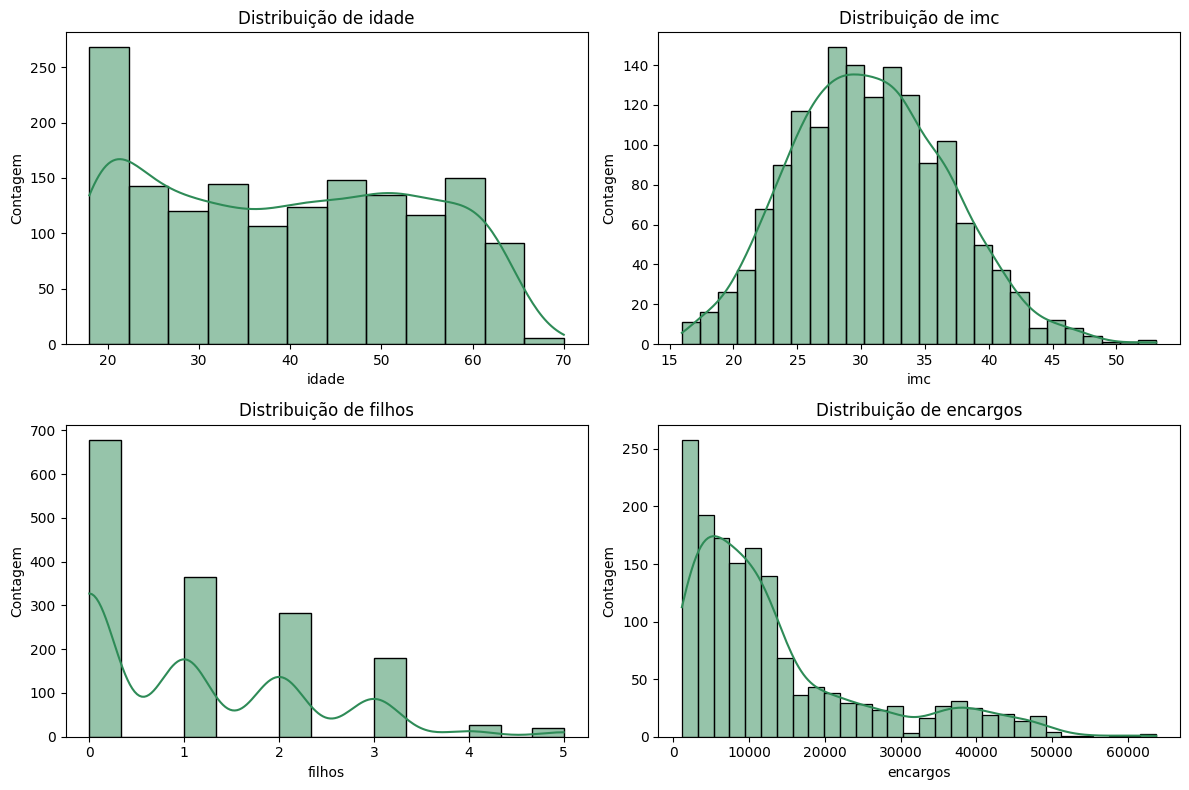

In [49]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 8))
for idx, column in enumerate(['idade', 'imc', 'filhos', 'encargos']):
    plt.subplot(2, 2, idx + 1)
    ax = sns.histplot(raw[column], kde=True, color='seagreen', edgecolor='k')
    ax.set_ylabel('Contagem')
    plt.title(f'Distribuição de {column}')
plt.tight_layout()
plt.show()

### Pair Plot Graphs

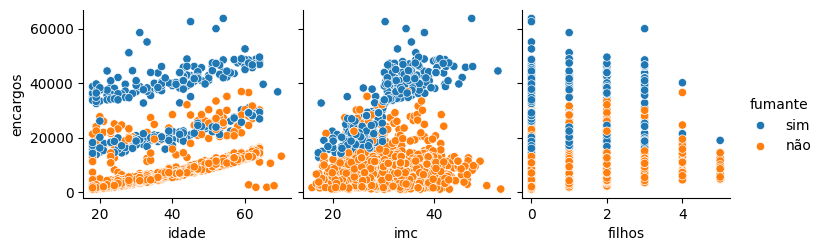

In [50]:
sns.pairplot(raw, hue='fumante', y_vars=["encargos"], x_vars=["idade", "imc", "filhos"])
plt.show()

## **Model Train**

### Imports

In [51]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split

### Step 1: Processing

In [52]:
X = raw.drop('encargos', axis=1)
y = raw['encargos']

categorical_cols = ['fumante', 'regiao']
numerical_cols = ['genero', 'idade', 'imc', 'filhos']

numerical_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(drop='first')

preprocessor = ColumnTransformer(
    transformers=[
        ('numericos', numerical_transformer, numerical_cols),
        ('categoricos', categorical_transformer, categorical_cols)
    ]
)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [53]:
df_models = pd.DataFrame(columns=['Model', 'R2', 'MAE', 'MSE'])

### Step 2: Model Building and Evaluation

#### Linear Regression Model

In [54]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline

linear_reg_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', LinearRegression())
])

linear_reg_pipeline.fit(X_train, y_train)
pred_linear_reg = linear_reg_pipeline.predict(X_test)

mse = round(mean_squared_error(y_test, pred_linear_reg), 3)
mae = round(mean_absolute_error(y_test, pred_linear_reg), 3)
r2score = round(r2_score(y_test, pred_linear_reg), 3)

print(f"Mean Squared Error: {mse}")
print(f"Mean Absolute Error: {mae}")
print(f"R squared: {r2score}")

df_models.loc[len(df_models)] = {'Model': 'Linear Regression', 'R2': r2score, 'MAE': mae, 'MSE': mse}
df_models

Mean Squared Error: 40532231.449
Mean Absolute Error: 4283.941
R squared: 0.714


,Model,R2,MAE,MSE
0,Linear Regression,0.714,4283.941,40532231.449


#### K-Nearest Neighbors (KNN)

In [55]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsRegressor

knn_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', KNeighborsRegressor())
])

param_grid_knn = {
    'model__n_neighbors': [2, 3, 4, 5, 6, 7],
    'model__metric': ['euclidean', 'manhattan'],
    'model__weights': ['uniform', 'distance']
}

grid_search_knn = GridSearchCV(knn_pipeline, param_grid_knn, cv=5, scoring='neg_mean_squared_error', n_jobs = -1)

grid_search_knn.fit(X_train, y_train)

best_knn_model = grid_search_knn.best_estimator_
knn_predictions = best_knn_model.predict(X_test)

mse = round(mean_squared_error(y_test, knn_predictions), 3)
mae = round(mean_absolute_error(y_test, knn_predictions), 3)
r2score = round(r2_score(y_test, knn_predictions), 3)

print(f"Mean Squared Error: {mse}")
print(f"Mean Absolute Error: {mae}")
print(f"R squared: {r2score}")

df_models.loc[len(df_models)] = {'Model': 'K-Nearest Neighbors', 'R2': r2score, 'MAE': mae, 'MSE': mse}
df_models

Mean Squared Error: 38583807.678
Mean Absolute Error: 3173.497
R squared: 0.728


,Model,R2,MAE,MSE
0,Linear Regression,0.714,4283.941,40532231.449
1,K-Nearest Neighbors,0.728,3173.497,38583807.678


### Decision Tree Regressor

In [56]:
from sklearn.tree import DecisionTreeRegressor, plot_tree

decision_tree_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', DecisionTreeRegressor())
])

param_grid_decision_tree = {
    'model__criterion': ['squared_error', 'friedman_mse', 'poisson'],
    'model__max_depth': [None, 10, 20, 30, 40, 50],
    'model__min_samples_split': [2, 5, 10],
    'model__min_samples_leaf': [1, 2, 4],
    'model__max_features': [None, 'sqrt', 'log2'],
    'model__max_leaf_nodes': [None, 10, 20, 30]
}

grid_search_decision_tree = GridSearchCV(decision_tree_pipeline, param_grid_decision_tree, cv=5, scoring='neg_mean_squared_error', n_jobs = -1)

grid_search_decision_tree.fit(X_train, y_train)

best_decision_tree_model = grid_search_decision_tree.best_estimator_
decision_tree_predictions = grid_search_decision_tree.predict(X_test)


mse = round(mean_squared_error(y_test, decision_tree_predictions), 3)
mae = round(mean_absolute_error(y_test, decision_tree_predictions), 3)
r2 = round(r2_score(y_test, decision_tree_predictions), 3)

print(f"Mean Squared Error: {mse}")
print(f"Mean Absolute Error: {mae}")
print(f"R squared: {r2}")

df_models.loc[len(df_models)] = {'Model': 'Decision Tree', 'R2': r2, 'MAE': mae, 'MSE': mse}
df_models

Mean Squared Error: 22720716.305
Mean Absolute Error: 2809.737
R squared: 0.84


,Model,R2,MAE,MSE
0,Linear Regression,0.714,4283.941,40532231.449
1,K-Nearest Neighbors,0.728,3173.497,38583807.678
2,Decision Tree,0.840,2809.737,22720716.305


## **Documentation**

Foram realizados testes com 3 modelos de regressão, sendo eles:

- Linear Regression
- K-Nearest Neighbors (KNN)
- Decision Tree Regressor

Foi usando 20% dos dados para teste e 80% para treinamento.

Após o treinamento, os modelos foram avaliados com base no R², MSE e MAE.

Onde cada um desses valores representa:
- **R²**: O coeficiente de determinação, que é uma métrica que mede a qualidade do modelo. (Quanto mais próximo de 1, melhor)
- **MSE**: O erro quadrático médio, que é uma métrica que mede a média dos quadrados dos erros. (Quanto mais próximo de 0, melhor)
- **MAE**: O erro médio absoluto, que é uma métrica que mede a média dos erros. (Quanto mais próximo de 0, melhor)

### Results

| **Model**               | **R2**  | **MAE**  | **MSE**      |
| ----------------------- | ------- | -------- | ------------ |
| **Linear Regression**   | 0.714   | 4283.941 | 40532231.449 |
| **K-Nearest Neighbors** | 0.749   | 3180.314 | 35651780.667 |
| **Decision Tree**       | 0.840   | 2809.737 | 22720716.305 |


### Conclusion

Baseados nos resultados obtidos, podemos concluir que o modelo de `Decision Tree Regressor` foi o que obteve o melhor resultado, com um R² de ~0.84



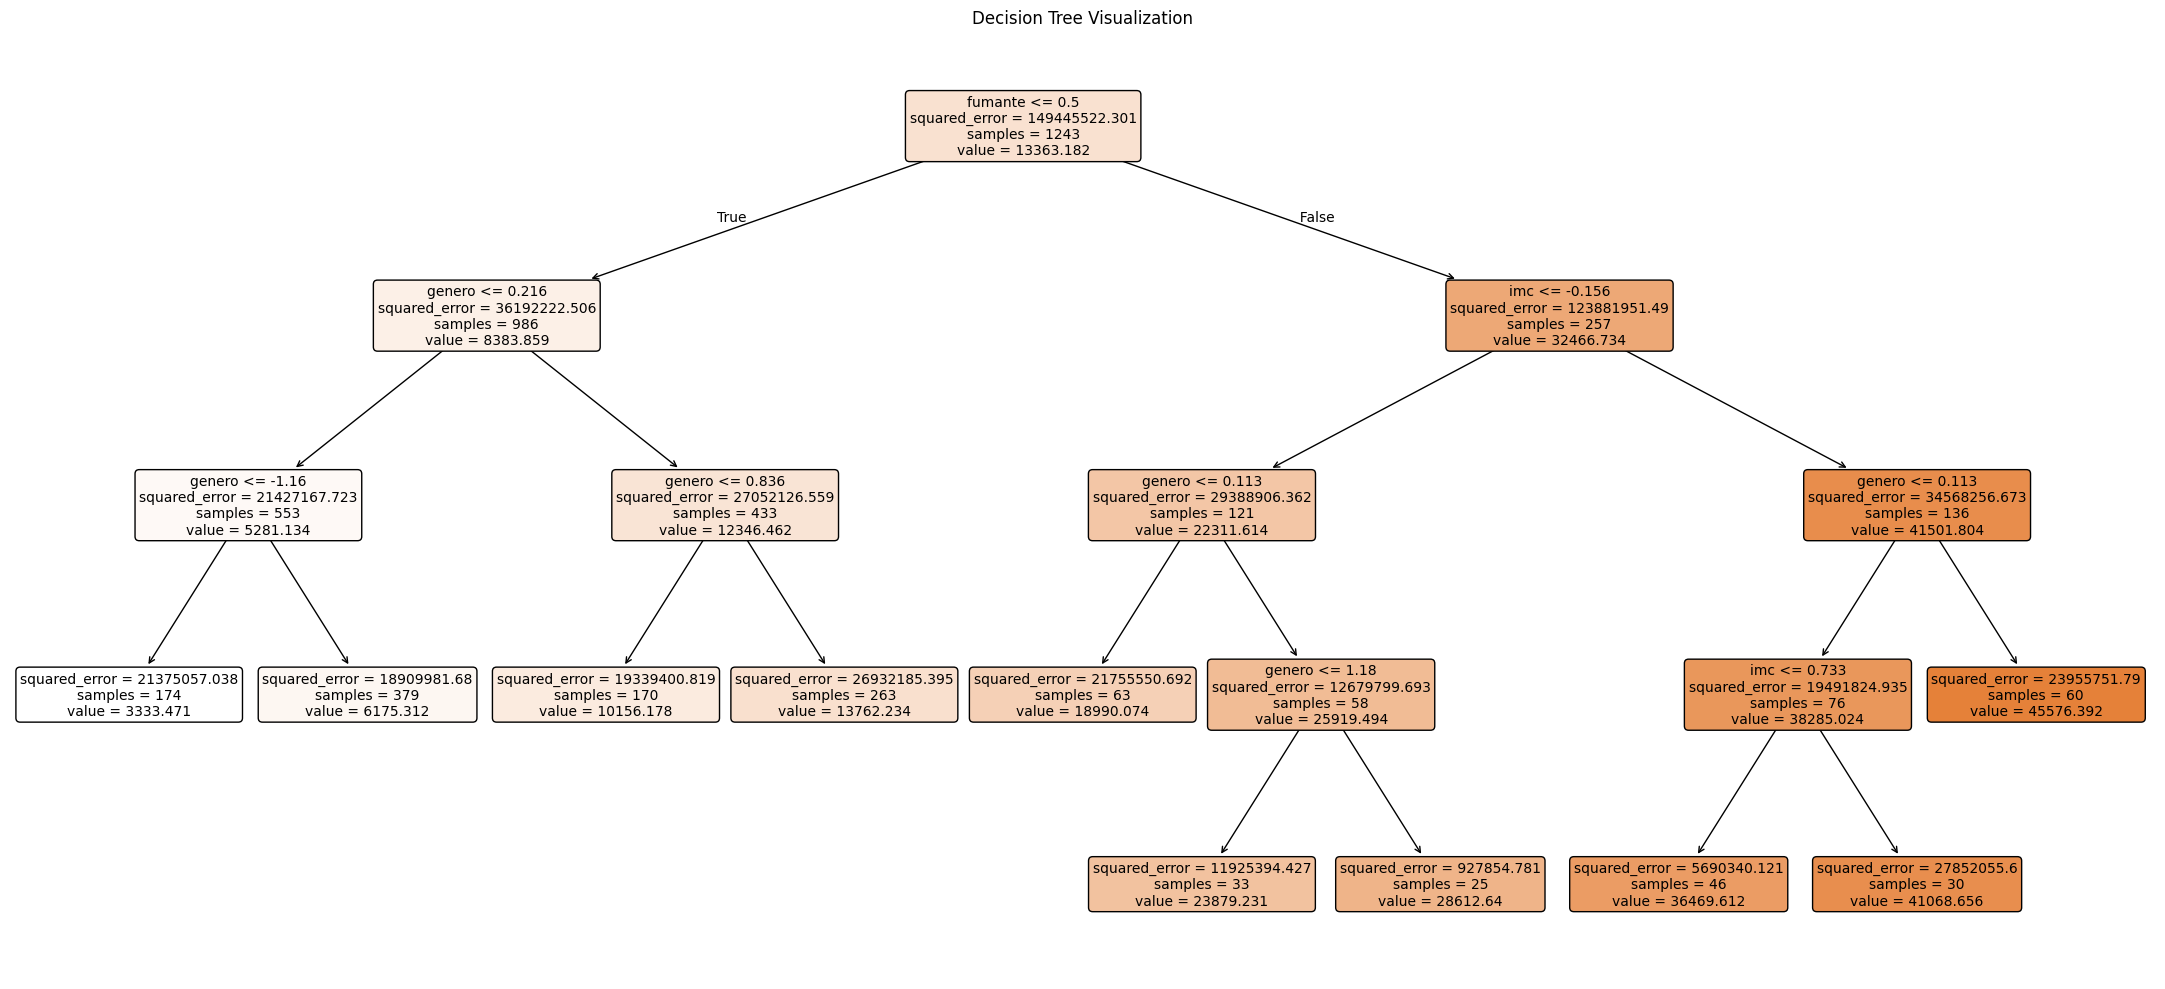

In [58]:

# Create a separate figure for the Decision Tree structure
plt.figure(figsize=(22, 10))
plt.subplot(1, 1, 1)
plot_tree(best_decision_tree_model.named_steps['model'],
          feature_names=X_train.columns,
          filled=True,
          rounded=True,
          fontsize=10)
plt.title('Decision Tree Visualization')
plt.xticks(rotation=90)

plt.tight_layout()
plt.show()